In [1]:
%%capture
!pip install --upgrade timm -q
!pip install --upgrade wandb -q
!pip install segmentation_models_pytorch -q
!pip install -qq pytorch-lightning h5py pandas

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- EfficientNet (e.g., EfficientNet-B0): Lightweight, performs well on image classification tasks, and scales efficiently.
- ResNet (e.g., ResNet18, ResNet34): Good for general-purpose feature extraction with relatively low complexity.
- MobileNetV3: Designed for mobile and resource-constrained environments with good performance.
- DenseNet121: Compact and efficient for feature reuse, which can be helpful in detecting patterns like settlements.
- ConvNeXt-Tiny: A modern architecture that’s compact but powerful.
- ResNet10T: Very lightweight and can be effective for small-scale tasks.

### Import libraries

In [1]:
import numpy as np
import gc
import h5py
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import timm
import pytorch_lightning as pl
from torch import nn, optim
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, Subset, DataLoader
import segmentation_models_pytorch as smp
from torchmetrics import Accuracy, AUROC
import wandb


    -Blue
    -Green
    -Red
    -Near-infrared (NIR)
    -Shortwave infrared 1 (SWIR1)
    -Shortwave infrared 2 (SWIR2)

In [2]:
## Login to wandb
import wandb
wandb.login(key='09aeb48d63e49b06fdbd153c97ef7e0ee6cb878d')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: micadee19. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
config = dict(
    model_name= 'resnet18',
    pretrained=True,
    only_rgb=False,
    mean=None,
    std=None,
    dropout=0.0,
    lr=1e-4,
    weight_decay=5e-2,
    max_epochs=1,
    patience=3,
    batch_size=100, #128,
    focal=True,
)

### Load data for machine learning

In [4]:
data_root = '/content/drive/MyDrive/human_settlement_mapping'

In [5]:
%%time
# Path to your HDF5 file
hdf5_file = f"{data_root}/train_data.h5"

# Open the HDF5 file
with h5py.File(hdf5_file, 'r') as hdf:
    # Extract the images (X)
    X = np.array(hdf['images'])

    # Extract the labels (y)
    y = np.array(hdf['labels'])

# Check the shapes to ensure they are correct
print("Shape of X (images):", X.shape)
print("Shape of y (labels):", y.shape)

hdf5_file_test = f"{data_root}/test_data.h5"
# Open the HDF5 file
with h5py.File(hdf5_file_test, 'r') as hdf:
    # Extract the images (X)
    X_test = np.array(hdf['images'])

# Check the shapes to ensure they are correct
print("Shape of X_test (images):", X_test.shape)

Shape of X (images): (1100000, 16, 16, 6)
Shape of y (labels): (1100000,)
Shape of X_test (images): (120000, 16, 16, 6)
CPU times: user 1min, sys: 6.3 s, total: 1min 6s
Wall time: 1min 14s


In [6]:
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch

class SatelliteImageDataset(Dataset):
    def __init__(self, images, labels=None, mean=None, std=None, transform=None):
        """
        Args:
            images: List or tensor of images.
            labels: List or tensor of labels (optional for test data).
            mean: Mean for normalization (can be a tensor or list).
            std: Standard deviation for normalization (can be a tensor or list).
            transform: Optional transform to be applied on a sample.
        """
        self.transform = transform
        self.images = images
        self.labels = labels
        self.mean = mean if mean is not None else torch.tensor([0.0])
        self.std = std if std is not None else torch.tensor([1.0])

        self.mean = torch.tensor(self.mean)
        self.std = torch.tensor(self.std)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        # Convert to float tensor and replace missing values (-9999) with NaN
        image = torch.tensor(image, dtype=torch.float32)
        image[image == -9999] = torch.nan

        # Average over the channels to reduce to 1 channel
        image = torch.nanmean(image, dim=0)
        image = image.unsqueeze(0)  # Add channel dimension back

        # Resize image to (224, 224)
        image = F.interpolate(image.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

        if self.transform:
            image = self.transform(image)

        # Use only the first value of mean and std for normalization
        mean = self.mean[0].view(1, 1, 1).expand_as(image)
        std = self.std[0].view(1, 1, 1).expand_as(image)

        image = (image - mean.to(image.device)) / std.to(image.device)
        image = torch.nan_to_num(image, 0)

        if self.labels is not None:
            # Return image and corresponding label for training/validation
            label = self.labels[idx]
            return image, torch.tensor(label, dtype=torch.long)
        else:
            # Return only the image for test data
            return image


In [7]:
# all_mean = []
# all_std = []

# for k in tqdm(range(len(X))):
#     x = X[k]
#     x = np.where(x==-9999, np.nan, x)
#     x_mean = np.nanmean(x, axis=(0,1))
#     x_std = np.nanstd(x, axis=(0,1))
#     all_mean.append(x_mean)
#     all_std.append(x_std)

In [8]:
# data_mean = np.mean(all_mean, axis=0)
# data_std = np.mean(all_std, axis=0)
# del all_mean, all_std
# gc.collect()

In [9]:
data_mean = np.array([1563.79248444, 1563.79001356, 1561.50078137, 1561.50280023, 1562.52022583, 1562.51923616])
data_std = np.array([838.00999403, 838.01471256, 835.72691994, 835.73440201, 834.43898481, 834.44672857])

In [10]:
# ## preprocess the data

# # remove missing value
# X = np.where(X==-9999, np.nan, X)
# X_test = np.where(X_test==-9999, np.nan, X_test)

# gc.collect()

In [11]:
# ## preprocess the data

# # scale data
# x_mean = np.nanmean(X, axis=(0,1,2))
# x_std = np.nanstd(X, axis=(0,1,2))

# gc.collect()

In [12]:
np.unique(y, return_counts=True)

(array([0, 1]), array([1000000,  100000]))

In [13]:
def plot_sample(k):
    image = X[k]
    _, axes = plt.subplots(2,3, figsize=(5,3))
    axes = axes.flatten()
    print(f"y = {y[k]}")
    for data, axis in zip(image.transpose(2, 0, 1), axes):
        axis.imshow(data)
    plt.show()

y = 0


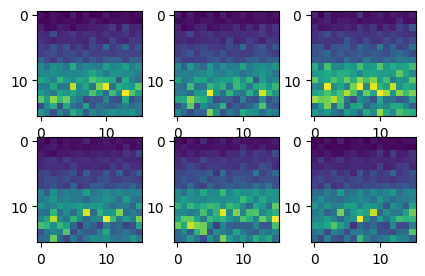

In [14]:
plot_sample(90)

In [15]:
# Step 2: Get indices of 0's and 1's in y
ones_indices = np.where(y == 1)[0]
zeros_indices = np.where(y == 0)[0]

y = 1


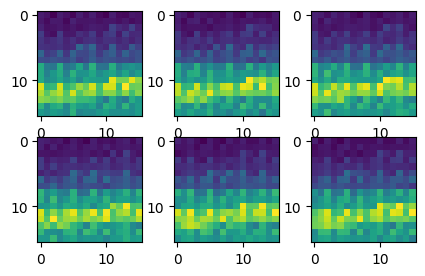

In [16]:
k = np.random.choice(ones_indices)
plot_sample(k)

799158
y = 0


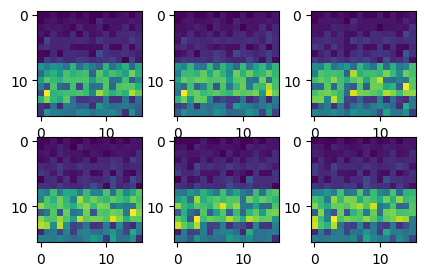

In [17]:
k = np.random.choice(zeros_indices)
print(k)
plot_sample(k)

In [18]:
# class DataTransformer:
#     def __init__(self, mean=None, std=None, img_size=512):
#         if mean is None:
#             mean = torch.zeros(1)

#         if std is None:
#             std = torch.ones(1)
#         self.mean = mean.reshape(1,-1,1,1)
#         self.std = std.reshape(1,-1,1,1)
#         self.resize = transforms.Resize((img_size, img_size))  # Ensure 512x512 size

#     def __call__(self, x):
#         x = x.float()
#         x[x == -9999] = torch.nan

#         x = (x - self.mean.to(x.device)) / self.std.to(x.device)
#         x = torch.nan_to_num(x, 0)  # fix nan as zero

#         # Resize to 512x512
#         x = self.resize(x)
#         return x

In [19]:
#class DataTransformer:
 #   def __init__(self, mean=None, std=None):
#        if mean is None:
#            mean = torch.zeros(1)
#
#        if std is None:
 #           std = torch.ones(1)
  #      self.mean = mean.reshape(1,-1,1,1)
   #     self.std = std.reshape(1,-1,1,1)

    #def __call__(self, x):
     #   x = x.float()
      #  x[x==-9999] = torch.nan

       # x = (x - self.mean.to(x.device)) / self.std.to(x.device)
       # x = torch.nan_to_num(x, 0) # fix nan as zero
        #return x

In [20]:
class SettlementModel(pl.LightningModule):
    def __init__(self, model_name='resnet18', pretrained=True, only_rgb=False, mean=None, std=None, dropout=0.0, lr=1e-4, weight_decay=5e-2, patience=5, focal=True, **kwargs):
        super().__init__()
        self.save_hyperparameters()

        in_chans = 1 #3 + 3*(not only_rgb)
        self.net = timm.create_model(model_name, in_chans=in_chans, num_classes=1, drop_rate=dropout, pretrained=pretrained)
        if focal:
            self.criterion = smp.losses.FocalLoss(mode='binary', alpha=None, gamma=2.0)
        else:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(10.))
        self.auc = AUROC(task="binary")

    def forward(self, x):
        x = x.float()  # Ensure input is float32
        if self.hparams.only_rgb:
            x = x[:, :3]
        return self.net(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=self.hparams.patience//2)
        lr_scheduler = {'scheduler': scheduler, 'interval': 'epoch', 'monitor': 'val_auc'}
        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler}

    def training_step(self, batch, batch_nb=0):
        image, target = batch
        pred = self(image)
        loss = self.criterion(pred, target)
        self.log('loss', loss, on_step=True, on_epoch=False, sync_dist=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_nb=0):
        image, target = batch
        pred = self(image)
        loss = self.criterion(pred, target)
        self.log('val_loss', loss, on_step=False, on_epoch=True, batch_size=image.shape[0], sync_dist=True, prog_bar=True)

        auc = self.auc(pred, target)
        self.log('val_auc', auc, on_step=False, on_epoch=True, batch_size=image.shape[0], sync_dist=True, prog_bar=True)

    def predict_step(self, batch, batch_nb=0):
      # No need to unpack as batch contains the images directly
      image = batch
      pred = self(image).sigmoid().flatten()
      return pred.cpu().numpy()



In [21]:
config['mean'] = torch.from_numpy(data_mean.astype('float32'))
config['std'] = torch.from_numpy(data_std.astype('float32'))

In [22]:
pl.seed_everything(42, workers=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#dst = TensorDataset(
#    torch.from_numpy(X.transpose(0,3,1,2)),
 #   torch.from_numpy(y.reshape(-1, 1)).float(),
#)

#train_dst = Subset(dst, train_index)
#val_dst = Subset(dst, val_index)

train_dst = SatelliteImageDataset(X_train, y_train, mean=data_mean, std=data_std)
val_dst = SatelliteImageDataset(X_val, y_val, mean=data_mean, std=data_std)

train_loader = DataLoader(train_dst, batch_size=config['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dst, batch_size=config['batch_size'], shuffle=False, num_workers=2)

model = SettlementModel(
    **config,
)

# callbacks
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename= '{epoch}-{val_auc:.6f}',
    monitor='val_auc',
    mode='max',
    verbose=False,
    save_last=True,
    save_weights_only=True,
)
early_stop = pl.callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=config['patience'],
    verbose=True,
)
progress_bar = pl.callbacks.TQDMProgressBar(refresh_rate=100)
callbacks = [
    checkpoint_callback,
    early_stop,
    progress_bar,
]
###
# training section
logger = pl.loggers.WandbLogger(
    save_dir='hms',
    name='hms',
)

trainer = pl.Trainer(
    accelerator='auto',
    devices='auto',
    precision='16-mixed',
    max_epochs=config['max_epochs'],
    callbacks=callbacks,
    logger=logger,
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: WARNING Path hms/wandb/ wasn't writable, using system temp directory.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | net       | ResNet      | 11.2 M | train
1 | criterion | FocalLoss   | 0      | train
2 | auc       | BinaryAUROC | 0      | train
--------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_auc improved. New best score: 0.657
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [23]:
test_dst = SatelliteImageDataset(images=X_test , mean=data_mean, std=data_std)
test_loader = DataLoader(test_dst, batch_size=config['batch_size'])

In [24]:
for x in test_loader:
    print(x.shape)
    break

torch.Size([20, 1, 224, 224])


In [25]:
preds = trainer.predict(ckpt_path='best', dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at hms/lightning_logs/6i37x39o/checkpoints/epoch=0-val_auc=0.657306.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at hms/lightning_logs/6i37x39o/checkpoints/epoch=0-val_auc=0.657306.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

In [26]:
preds = np.concatenate(preds, axis=0)
preds.shape

(120000,)

In [27]:
preds

array([0.2732, 0.1749, 0.2893, ..., 0.328 , 0.212 , 0.376 ], dtype=float16)

In [28]:
# np.unique(preds>0.6, return_counts=True)

In [29]:
ss = pd.read_csv(f'{data_root}/SampleSubmission.csv')
ss.head()

,id,class
0,id_f5l6neabz0,0
1,id_7u688i5j5v,0
2,id_wm2bkde80r,0
3,id_0e6spuo284,0
4,id_dm71xazj94,0


In [30]:
id_map = pd.read_csv(f'{data_root}/id_map.csv')
id_map.head()

,id,ID
0,id_xjoh8datmz,0
1,id_ui7ciy2r2l,1
2,id_le7254d4ch,2
3,id_99qf1p6vg0,3
4,id_jc5kg2grpc,4


In [31]:
sub = id_map.sort_values('ID').set_index('ID')
sub['class'] = preds
sub.head()

,id,class
ID,,
0,id_xjoh8datmz,0.273193
1,id_ui7ciy2r2l,0.174927
2,id_le7254d4ch,0.289307
3,id_99qf1p6vg0,0.226440
4,id_jc5kg2grpc,0.271240


In [32]:
sub.to_csv('Subb.csv', index=False)